<a href="https://colab.research.google.com/github/sasan73/Mangaka-Classifier/blob/master/Mangaka_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mangaka** *Classifier*


In [ ]:
from fastai.vision import *

In [ ]:
folder = "Eiichiro Oda"
file = "one-piece.csv"

In [ ]:
folder = "Yoshihiro Togashi"
file = "hunter-x-hunter.csv"

In [ ]:
folder = "Hajime Isayama"
file = "shingeki-no-kyojin.csv"

In [ ]:
folder = "Koyoharu Gotouge"
file = "kimetsu-no-yaiba.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = Path('/content/drive/My Drive/Data/Mangaka Classification')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
path.ls()

[PosixPath('/content/drive/My Drive/Data/Mangaka Classification/Koyoharu Gotouge'),
 PosixPath('/content/drive/My Drive/Data/Mangaka Classification/Hajime Isayama'),
 PosixPath('/content/drive/My Drive/Data/Mangaka Classification/Yoshihiro Togashi'),
 PosixPath('/content/drive/My Drive/Data/Mangaka Classification/Eiichiro Oda')]

In [ ]:
classes = ["Eiichiro Oda", "Hajime Isayama", "Koyoharu Gotouge", "Yoshihiro Togashi"]

In [ ]:
download_images??

In [ ]:
download_images(Path('/content/')/file, dest)

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

Eiichiro Oda


Hajime Isayama


Koyoharu Gotouge


Yoshihiro Togashi


In [ ]:
doc(ImageDataBunch.from_folder)

In [ ]:
tfms = (zoom_crop(scale = (0.8, 2.0), do_rand=True, p = 0.5),flip_lr(p=.5))

In [ ]:
np.random.seed(13)
bs = 64
data = (ImageList.from_folder(path)
                 .split_by_rand_pct(valid_pct=.2)
                 .label_from_folder()
                 .transform(tfms, size = (224, 224))
                 .databunch(bs = bs));

data.save('data')


In [ ]:
data = load_data(path, 'data')

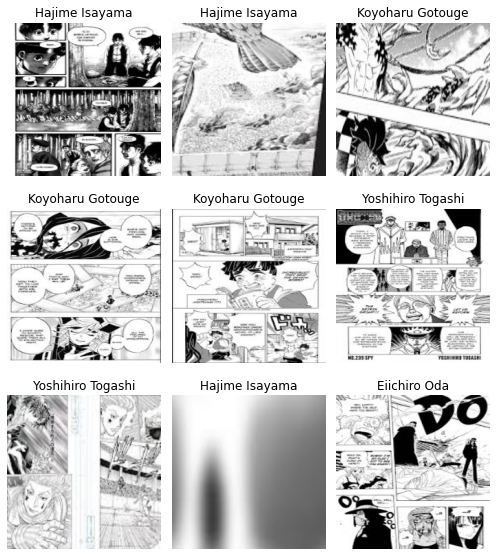

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
len(data.train_ds), len(data.valid_ds), data.classes

(1176,
 294,
 ['Eiichiro Oda', 'Hajime Isayama', 'Koyoharu Gotouge', 'Yoshihiro Togashi'])

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

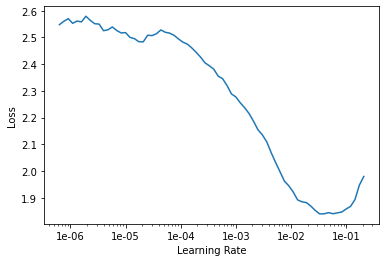

In [ ]:
learn.recorder.plot(skip_end= 10)

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-4, 1e-2), wd=.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.619749,2.679599,0.459184,01:34
1,1.308622,1.688844,0.411565,00:13
2,1.040486,1.064884,0.295918,00:12
3,0.869653,0.712649,0.224490,00:13


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [ ]:
learn.summary()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
learn.save("stage_1")

In [ ]:
learn.load("stage_1");

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


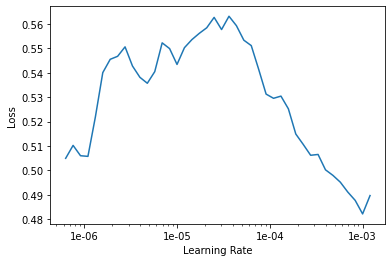

In [ ]:
learn.recorder.plot(skip_end= 32)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.566094,0.600442,0.176871,00:13


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2');

In [ ]:
learn.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


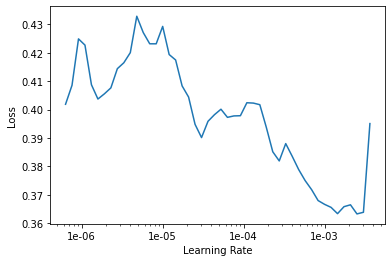

In [ ]:
learn.recorder.plot(skip_end=24)

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(5e-4, 1e-3), moms = (.8, .7), wd =.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.442944,0.992758,0.238095,00:13
1,0.583291,0.938894,0.224490,00:13
2,0.483443,0.637179,0.153061,00:13
3,0.362404,0.379658,0.108844,00:13
4,0.270985,0.357993,0.112245,00:13


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

In [ ]:
learn.save('fin-stage')

In [ ]:
learn.load('fin-stage');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample wi

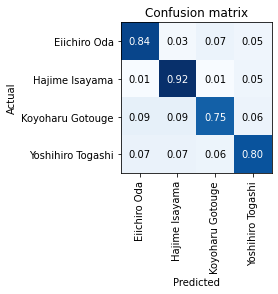

In [ ]:
interp.plot_confusion_matrix(learn)

In [ ]:
img = open_image('/content/one_piece_983_7.jpg')
type(img)
prediction = learn.predict(img)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
prediction

(Category tensor(0),
 tensor(0),
 tensor([9.6631e-01, 4.5655e-06, 2.3235e-05, 3.3657e-02]))

# Hooking and Model Interpretation


In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor

In [ ]:
img = Image.open('/content/one_piece_983_7.jpg')
img_tensor = ToTensor()(img).unsqueeze(0)

In [ ]:
k = Tensor([
                  [0, -5/3, 1],
                  [-5/3, -5/3, 1],
                  [1, 1, 1],
]).expand(1,3,3,3)/6

In [ ]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [ ]:
img_tensor

tensor([[[[1.0000, 0.9725, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 1.0000, 0.9490,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.9686, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.6941, 0.7098, 0.3922,  ..., 1.0000, 1.0000, 1.0000],
          [0.1020, 0.6431, 0.6235,  ..., 1.0000, 1.0000, 1.0000],
          [0.0078, 0.0078, 0.1608,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 0.9725, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 1.0000, 0.9490,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.9686, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.6941, 0.7098, 0.3922,  ..., 1.0000, 1.0000, 1.0000],
          [0.1020, 0.6431, 0.6235,  ..., 1.0000, 1.0000, 1.0000],
          [0.0078, 0.0078, 0.1608,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 0.9725, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 1.0000, 0.9490,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.9686, 1.0000,  ..., 1

In [ ]:
edge = F.conv2d(img_tensor, k)

In [ ]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

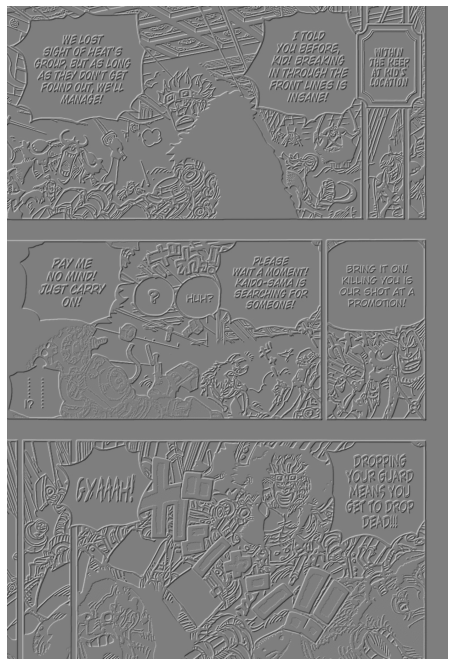

In [ ]:
show_image(edge[0], figsize =(12,12))